### TANZANIAN WATER WELLS

#### OVERVIEW

#### BUSINESS UNDERSTANDING

#### IMPORT LIBRARIES & DATA

In [1]:
# importing the neccessary libraries 
# Import relevant Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import cross_val_predict, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Scalers
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, LabelBinarizer, label_binarize

from sklearn.preprocessing import OneHotEncoder

In [2]:
# importing the csv files
labels = pd.read_csv('data\Training_set_labels.csv')

df = pd.read_csv('data/Training_set_values.csv')


In [3]:
#checking the shape of the dataframes
print('df: ', df.shape)
print('labels: ',labels.shape)

df:  (59400, 40)
labels:  (59400, 2)


In [4]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
df.loc[df['id'] != labels['id']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [7]:
#merge the 2 dataframes
df_1= pd.merge(df, labels, how = 'left', on='id')
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [8]:
#checking the merge with a specific id
df_1.loc[df_1['id'] == 8776] 

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
#checking the y classes
df_1['status_group'].value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

In [10]:
#grouping the values
df_1['status'] = np.where(df_1['status_group'] == "functional needs repair", 
                                'functional', df_1['status_group'])
df_1['status'].value_counts()

status
functional        36576
non functional    22824
Name: count, dtype: int64

In [11]:
#binary grouping
df_1['binary_status'] = np.where(df_1['status'] == 'functional', 1, 0)
df_1['binary_status'].value_counts()

binary_status
1    36576
0    22824
Name: count, dtype: int64

In [12]:
df_1.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### DATA CLEANING

In [13]:
df_1['scheme_management'].value_counts() 

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [14]:
df_1.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status,binary_status
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,functional,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,functional,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,functional,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,non functional,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,functional,1
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional,functional,1
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional,non functional,0
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,non functional,0
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional,non functional,0
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,functional,1


In [15]:
# checking the datatypes of the columns
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [16]:
#changing the datatypes of some columns
df_1['region_code']= df_1['region_code'].astype(str)
df_1['district_code'] = df_1['district_code'].astype(str)
df_1['construction_year'] = df_1['construction_year'].astype(str)
df_1['amount_tsh'] = df_1['amount_tsh'].astype(int)
df_1['permit'] = np.where(df_1['permit'] == True, 1, df_1['permit'])
df_1['permit'] = np.where(df_1['permit'] == False, 0, df_1['permit'])
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  int32  
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  object 
 14  district_code          59400 non-null  object 
 15  lg

In [17]:
df_1.loc[((df_1['permit'] != 0) &
             (df_1['permit'] != 1))] #locating Null 
df_1.drop(df_1[(df_1['permit'] != 0) & 
                       (df_1['permit'] != 1)].index, inplace=True)
df_1['permit'] = df_1['permit'].astype(int)

In [18]:
df_1['source_type'].value_counts()

source_type
shallow well            16253
spring                  15981
borehole                11162
river/lake              10013
rainwater harvesting     2039
dam                       630
other                     266
Name: count, dtype: int64

In [19]:
df_1['extraction_type_class'].value_counts()

extraction_type_class
gravity         25234
handpump        16048
other            6050
submersible      5854
motorpump        2704
rope pump         349
wind-powered      105
Name: count, dtype: int64

In [20]:
df_1['funder'].value_counts()

funder
Government Of Tanzania    9043
Danida                    3112
Hesawa                    2027
Rwssp                     1372
World Bank                1345
                          ... 
Comune Di Roma               1
Swifti                       1
Area                         1
Rwi                          1
Samlo                        1
Name: count, Length: 1834, dtype: int64

In [21]:
df_1['installer'].value_counts()

installer
DWE              17361
Government        1788
RWE               1203
Commu             1060
DANIDA            1049
                 ...  
B.A.P                1
R                    1
Nasan workers        1
TWESS                1
SELEPTA              1
Name: count, Length: 2056, dtype: int64

In [22]:
df_1.loc[df_1['installer'] == '-']
# there's construction year 0

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status,binary_status
10217,42616,0,2011-08-03,Kalebejo Parish,0,-,32.356645,-2.499427,Kalebejo Parish,0,...,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,functional,1
20968,10873,0,2011-07-26,Government Of Tanzania,0,-,32.677150,-2.508912,Kwa Madebele,0,...,enough,enough,lake,river/lake,surface,communal standpipe,communal standpipe,non functional,non functional,0
25769,21336,0,2011-07-26,Government Of Tanzania,0,-,32.674665,-2.506721,Health Center,0,...,enough,enough,lake,river/lake,surface,communal standpipe,communal standpipe,functional,functional,1


In [23]:
df_1['construction_year'].value_counts() 
#dropping this column

construction_year
0       19580
2008     2576
2009     2491
2010     2430
2000     1566
2007     1559
2006     1447
2003     1276
2011     1211
2004     1109
2002     1065
1978     1027
2012     1026
2005      985
1995      979
1999      954
1985      943
1998      924
1984      779
1996      768
1982      741
1972      705
1994      703
1974      676
1990      667
1980      647
1992      632
1997      613
1993      595
2001      533
1988      521
1983      487
1975      437
1986      433
1976      411
1991      323
1989      316
1970      310
1987      301
1981      238
1977      199
1979      192
1973      183
2013      173
1971      145
1967       86
1963       85
1968       68
1969       59
1960       45
1964       40
1962       29
1961       20
1965       19
1966       17
Name: count, dtype: int64

In [24]:
df_1['management'].value_counts()

management
vwc                 38296
wug                  6340
water board          2830
wua                  2468
private operator     1893
parastatal           1595
water authority       825
other                 744
company               658
unknown               519
other - school         99
trust                  77
Name: count, dtype: int64

In [25]:
df_1['quantity_group'].value_counts()

quantity_group
enough          31979
insufficient    13934
dry              5836
seasonal         3901
unknown           694
Name: count, dtype: int64

In [26]:
df_1['quality_group'].value_counts()

quality_group
good        48416
salty        5035
unknown      1399
milky         801
colored       490
fluoride      203
Name: count, dtype: int64

In [27]:
#dropping some specific wells
df_1.drop(df_1[(df_1['quantity_group'] == 'unknown') |
             (df_1['quality_group'] == 'unknown')].index, inplace=True)
df_1.shape

(54744, 43)

In [28]:
df_1['quantity_group'].value_counts()

quantity_group
enough          31851
insufficient    13830
dry              5202
seasonal         3861
Name: count, dtype: int64

In [29]:
df_1['quality_group'].value_counts()

quality_group
good        48246
salty        5007
milky         799
colored       489
fluoride      203
Name: count, dtype: int64

In [30]:
df_1['payment'].value_counts()

payment
never pay                23132
pay per bucket            8591
pay monthly               8167
unknown                   6628
pay when scheme fails     3728
pay annually              3533
other                      965
Name: count, dtype: int64

In [31]:
df_1.drop(['payment'], axis=1, inplace = True) 
#Dropping the payment column because it was initially thought to represent the cost of water, 
# but it actually indicates the payment method, which is not as useful for the goals of this project

In [32]:
df_1['amount_tsh'].value_counts()

amount_tsh
0         37625
500        3046
50         2310
1000       1431
20         1393
          ...  
53            1
138000        1
306           1
6300          1
59            1
Name: count, Length: 92, dtype: int64

In [33]:
columns_to_drop = ['date_recorded', 'funder', 'wpt_name', 'subvillage', 'lga', 
 'ward', 'recorded_by', 'scheme_name', 'extraction_type', 
 'extraction_type_group', 'management','quality_group', 
 'quantity', 'source', 'source_type', 'waterpoint_type', 'num_private', 
 'region_code', 'district_code']

# Drop the columns from dataset
df_1 = df_1.drop(columns_to_drop, axis=1)

In [34]:
# Check columns with missing values
df_1.isna().sum()

id                          0
amount_tsh                  0
gps_height                  0
installer                1117
longitude                   0
latitude                    0
basin                       0
region                      0
population                  0
public_meeting           2730
scheme_management        3487
permit                      0
construction_year           0
extraction_type_class       0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source_class                0
waterpoint_type_group       0
status_group                0
status                      0
binary_status               0
dtype: int64

In [35]:
# Create a list of missing-value columns
missing_value_columns = ['installer', 'public_meeting', 'scheme_management', 'permit']

# Check the value counts
for col in missing_value_columns:
    print(df_1[col].value_counts())

installer
DWE                      16899
Government                1674
RWE                       1151
DANIDA                    1041
Commu                     1025
                         ...  
harison                      1
MSIGWA                       1
Singida yetu                 1
MINISTRY OF EDUCATION        1
SELEPTA                      1
Name: count, Length: 2011, dtype: int64
public_meeting
True     47455
False     4559
Name: count, dtype: int64
scheme_management
VWC                 33712
WUG                  4943
Water authority      2898
WUA                  2747
Water Board          2640
Parastatal           1495
Company              1030
Private operator     1016
Other                 608
SWC                    97
Trust                  71
Name: count, dtype: int64
permit
1    37948
0    16796
Name: count, dtype: int64


In [36]:
df_1.info() #checking cleaned dataset

<class 'pandas.core.frame.DataFrame'>
Index: 54744 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     54744 non-null  int64  
 1   amount_tsh             54744 non-null  int32  
 2   gps_height             54744 non-null  int64  
 3   installer              53627 non-null  object 
 4   longitude              54744 non-null  float64
 5   latitude               54744 non-null  float64
 6   basin                  54744 non-null  object 
 7   region                 54744 non-null  object 
 8   population             54744 non-null  int64  
 9   public_meeting         52014 non-null  object 
 10  scheme_management      51257 non-null  object 
 11  permit                 54744 non-null  int32  
 12  construction_year      54744 non-null  object 
 13  extraction_type_class  54744 non-null  object 
 14  management_group       54744 non-null  object 
 15  payment

In [37]:
# Drop rows with missing values in 'installer' and 'scheme_management' columns
df_1.dropna(subset=['installer', 'scheme_management'], axis=0, inplace=True)

In [38]:
# Fill missing values in funder and installer and scheme_management columns with 'Other'
for col in ['public_meeting', 'permit']:
    df_1[col] = df[col].fillna(True)

In [39]:
# Confirm there are no more missing values
df_1.isna().sum()

id                       0
amount_tsh               0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quantity_group           0
source_class             0
waterpoint_type_group    0
status_group             0
status                   0
binary_status            0
dtype: int64

In [40]:
df_1.shape

(50166, 23)

In [41]:
df_1.describe() #looking for outliers

,id,amount_tsh,gps_height,longitude,latitude,population,binary_status
count,50166.000000,50166.000000,50166.000000,50166.000000,5.016600e+04,50166.000000,50166.000000
mean,37140.276343,348.388670,697.901248,34.160264,-5.680130e+00,176.615576,0.627915
std,21443.386912,2793.108425,697.281175,6.473404,2.909040e+00,467.986126,0.483366
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,18569.500000,0.000000,0.000000,33.067725,-8.226623e+00,0.000000,0.000000
50%,37095.500000,0.000000,463.000000,35.096511,-4.982342e+00,35.000000,1.000000
75%,55674.750000,40.000000,1332.000000,37.300843,-3.324285e+00,200.000000,1.000000
max,74247.000000,250000.000000,2770.000000,40.323402,-2.000000e-08,30500.000000,1.000000


<Axes: >

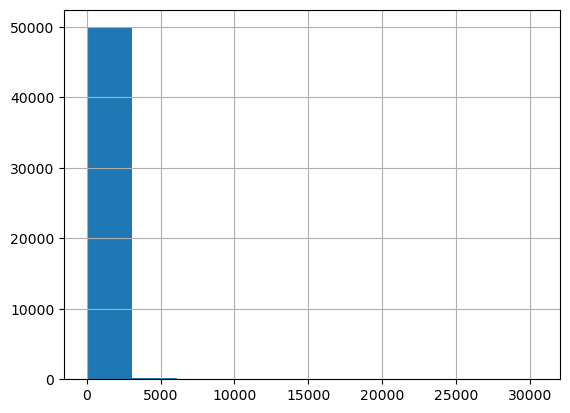

In [42]:
df_1['population'].hist()

<Axes: >

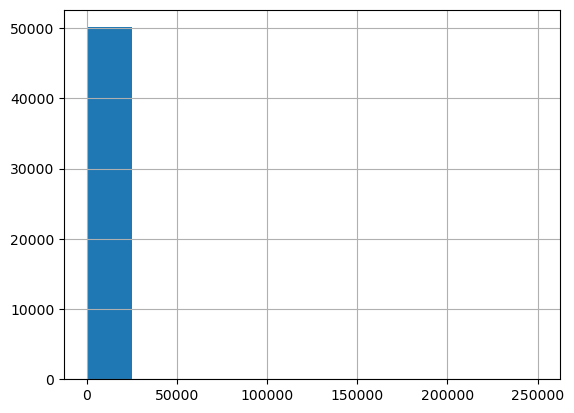

In [43]:
df_1['amount_tsh'].hist()

#### MODELLING

#### DATA PROCESSING

In [44]:
# Assign status_group column to y series
y = df_1['status_group']

# Drop status_group to create X dataframe
X = df_1.drop('status_group', axis=1)

# Print first 5 rows of X
X.head()

,id,amount_tsh,gps_height,installer,longitude,latitude,basin,region,population,public_meeting,...,construction_year,extraction_type_class,management_group,payment_type,water_quality,quantity_group,source_class,waterpoint_type_group,status,binary_status
0,69572,6000,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,109,True,...,1999,gravity,user-group,annually,soft,enough,groundwater,communal standpipe,functional,1
1,8776,0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,280,True,...,2010,gravity,user-group,never pay,soft,insufficient,surface,communal standpipe,functional,1
2,34310,25,686,World vision,37.460664,-3.821329,Pangani,Manyara,250,True,...,2009,gravity,user-group,per bucket,soft,enough,surface,communal standpipe,functional,1
3,67743,0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,58,True,...,1986,submersible,user-group,never pay,soft,dry,groundwater,communal standpipe,non functional,0
5,9944,20,0,DWE,39.172796,-4.765587,Pangani,Tanga,1,True,...,2009,submersible,user-group,per bucket,salty,enough,unknown,communal standpipe,functional,1


In [45]:
X.dtypes #looking into data types of X 

id                         int64
amount_tsh                 int32
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
population                 int64
public_meeting              bool
scheme_management         object
permit                      bool
construction_year         object
extraction_type_class     object
management_group          object
payment_type              object
water_quality             object
quantity_group            object
source_class              object
waterpoint_type_group     object
status                    object
binary_status              int32
dtype: object

In [46]:
#One-hot encoding of categorical features
# Create lists of categorical, continuous, and binary columns
cat_col = ['installer', 'basin', 'region', 'scheme_management', 
           'extraction_type_class', 'management_group', 'payment_type', 
           'water_quality', 'quantity_group', 'source_class','status', 
           'waterpoint_type_group']

cont_col = ['amount_tsh','gps_height','longitude','latitude','population','construction_year']

binary_col = ['public_meeting', 'permit']

In [47]:
# Transformer for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_col),
        ('cat', OneHotEncoder(), cat_col)
    ])

# Create a pipeline with preprocessing and logistic regression
pipe_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [48]:
#Create dummies
X = pd.get_dummies(X, columns=cat_col)

# Print X
X

,id,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,binary_status,...,source_class_surface,source_class_unknown,status_functional,status_non functional,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,69572,6000,1390,34.938093,-9.856322,109,True,False,1999,1,...,False,False,True,False,False,True,False,False,False,False
1,8776,0,1399,34.698766,-2.147466,280,True,True,2010,1,...,True,False,True,False,False,True,False,False,False,False
2,34310,25,686,37.460664,-3.821329,250,True,True,2009,1,...,True,False,True,False,False,True,False,False,False,False
3,67743,0,263,38.486161,-11.155298,58,True,True,1986,0,...,False,False,False,True,False,True,False,False,False,False
5,9944,20,0,39.172796,-4.765587,1,True,True,2009,1,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,11164,500,351,37.634053,-6.124830,89,True,True,2007,0,...,False,False,False,True,False,True,False,False,False,False
59395,60739,10,1210,37.169807,-3.253847,125,True,True,1999,1,...,False,False,True,False,False,True,False,False,False,False
59396,27263,4700,1212,35.249991,-9.070629,56,True,True,1996,1,...,True,False,True,False,False,True,False,False,False,False
59398,31282,0,0,35.861315,-6.378573,0,True,True,0,1,...,False,False,True,False,False,False,False,True,False,False


##### Train - Test split

In [49]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size= 0.2, random_state=42)

##### Baseline Machine Learning Model

In [50]:
# Check statistics of the training data
X_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,population,binary_status
count,40132.000000,40132.000000,40132.000000,40132.000000,4.013200e+04,40132.000000,40132.000000
mean,37195.793830,349.371449,696.678611,34.156385,-5.677741e+00,175.895520,0.628725
std,21452.177156,2712.104242,696.856772,6.465239,2.910559e+00,464.305442,0.483152
min,2.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,18621.250000,0.000000,0.000000,33.058197,-8.228237e+00,0.000000,0.000000
50%,37178.500000,0.000000,462.000000,35.094331,-4.989152e+00,35.000000,1.000000
75%,55742.000000,40.000000,1330.000000,37.293347,-3.323019e+00,200.000000,1.000000
max,74247.000000,250000.000000,2770.000000,40.323402,-2.000000e-08,30500.000000,1.000000


In [51]:
# Initiate metrics list 
metrics_list=[]

class Metrics:
    def model_score(self, model, y_true, y_pred):
        # Print classification report, accuracy, precision, recall, f1_score 
        print(classification_report(y_true, y_pred))
        print("Overall accuracy score", accuracy_score(y_true, y_pred))
        print("Overall precision score", precision_score(y_true, y_pred, average='weighted'))
        print("Overall recall score", recall_score(y_true, y_pred, average='weighted'))
        print("Overall F1-score", f1_score(y_true, y_pred, average='weighted'))

        # Print a confusion matrix    
        cnf_matrix = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=model.classes_)
        print('\nConfusion Matrix')       
        return disp.plot()

    # Create a list of model metrics
    def get_metrics(self, model_name, model, y_true, y_pred):  #y_test, X_test, model
        metrics = {}  
        metrics['model_name'] = model_name
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['f1 score'] = f1_score(y_true, y_pred, average='weighted')
        metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
        metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
        metrics_list.append(metrics)
        return metrics_list

In [52]:
# Baseline model pipeline
# pipeline for baseline logistic regression
pipe_logistic = Pipeline([('ss', StandardScaler()), 
                    ('lr', LogisticRegression(random_state=42))])

# pipeline for baseline decision tree classification
pipe_decision_tree = Pipeline([('ss', StandardScaler()), 
                    ('tree', DecisionTreeClassifier(random_state=42))])

#### LOGISTIC REGRESSION MODEL

In [53]:
# Fit the logistic regression pipeline to the training data
log_model = pipe_logistic.fit(X_train, y_train)
# Print the accuracy on test set
pipe_logistic.score(X_test, y_test)

0.9364161849710982

                         precision    recall  f1-score   support

             functional       0.91      0.98      0.95      5579
functional needs repair       0.61      0.20      0.31       689
         non functional       1.00      1.00      1.00      3766

               accuracy                           0.94     10034
              macro avg       0.84      0.73      0.75     10034
           weighted avg       0.92      0.94      0.92     10034

Overall accuracy score 0.9364161849710982
Overall precision score 0.9227758355018202
Overall recall score 0.9364161849710982
Overall F1-score 0.9218428472967931

Confusion Matrix


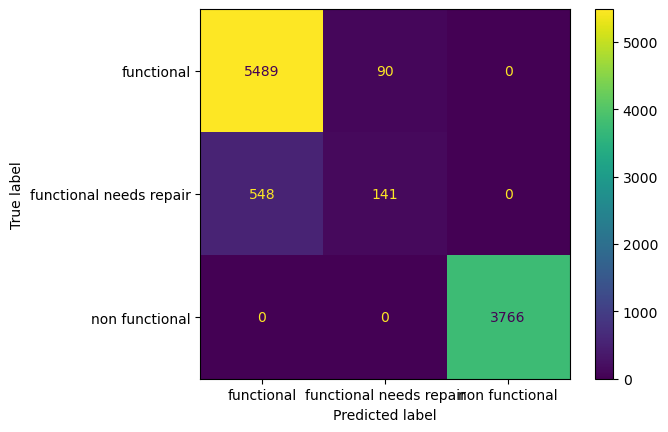

In [54]:
# Print model metrics
# Predict target
y_pred = log_model.predict(X_test)

# Create metrics object
score_metrics = Metrics()

# Print classification report, scores, and confusion matrix
score_metrics.model_score(log_model, y_test, y_pred)

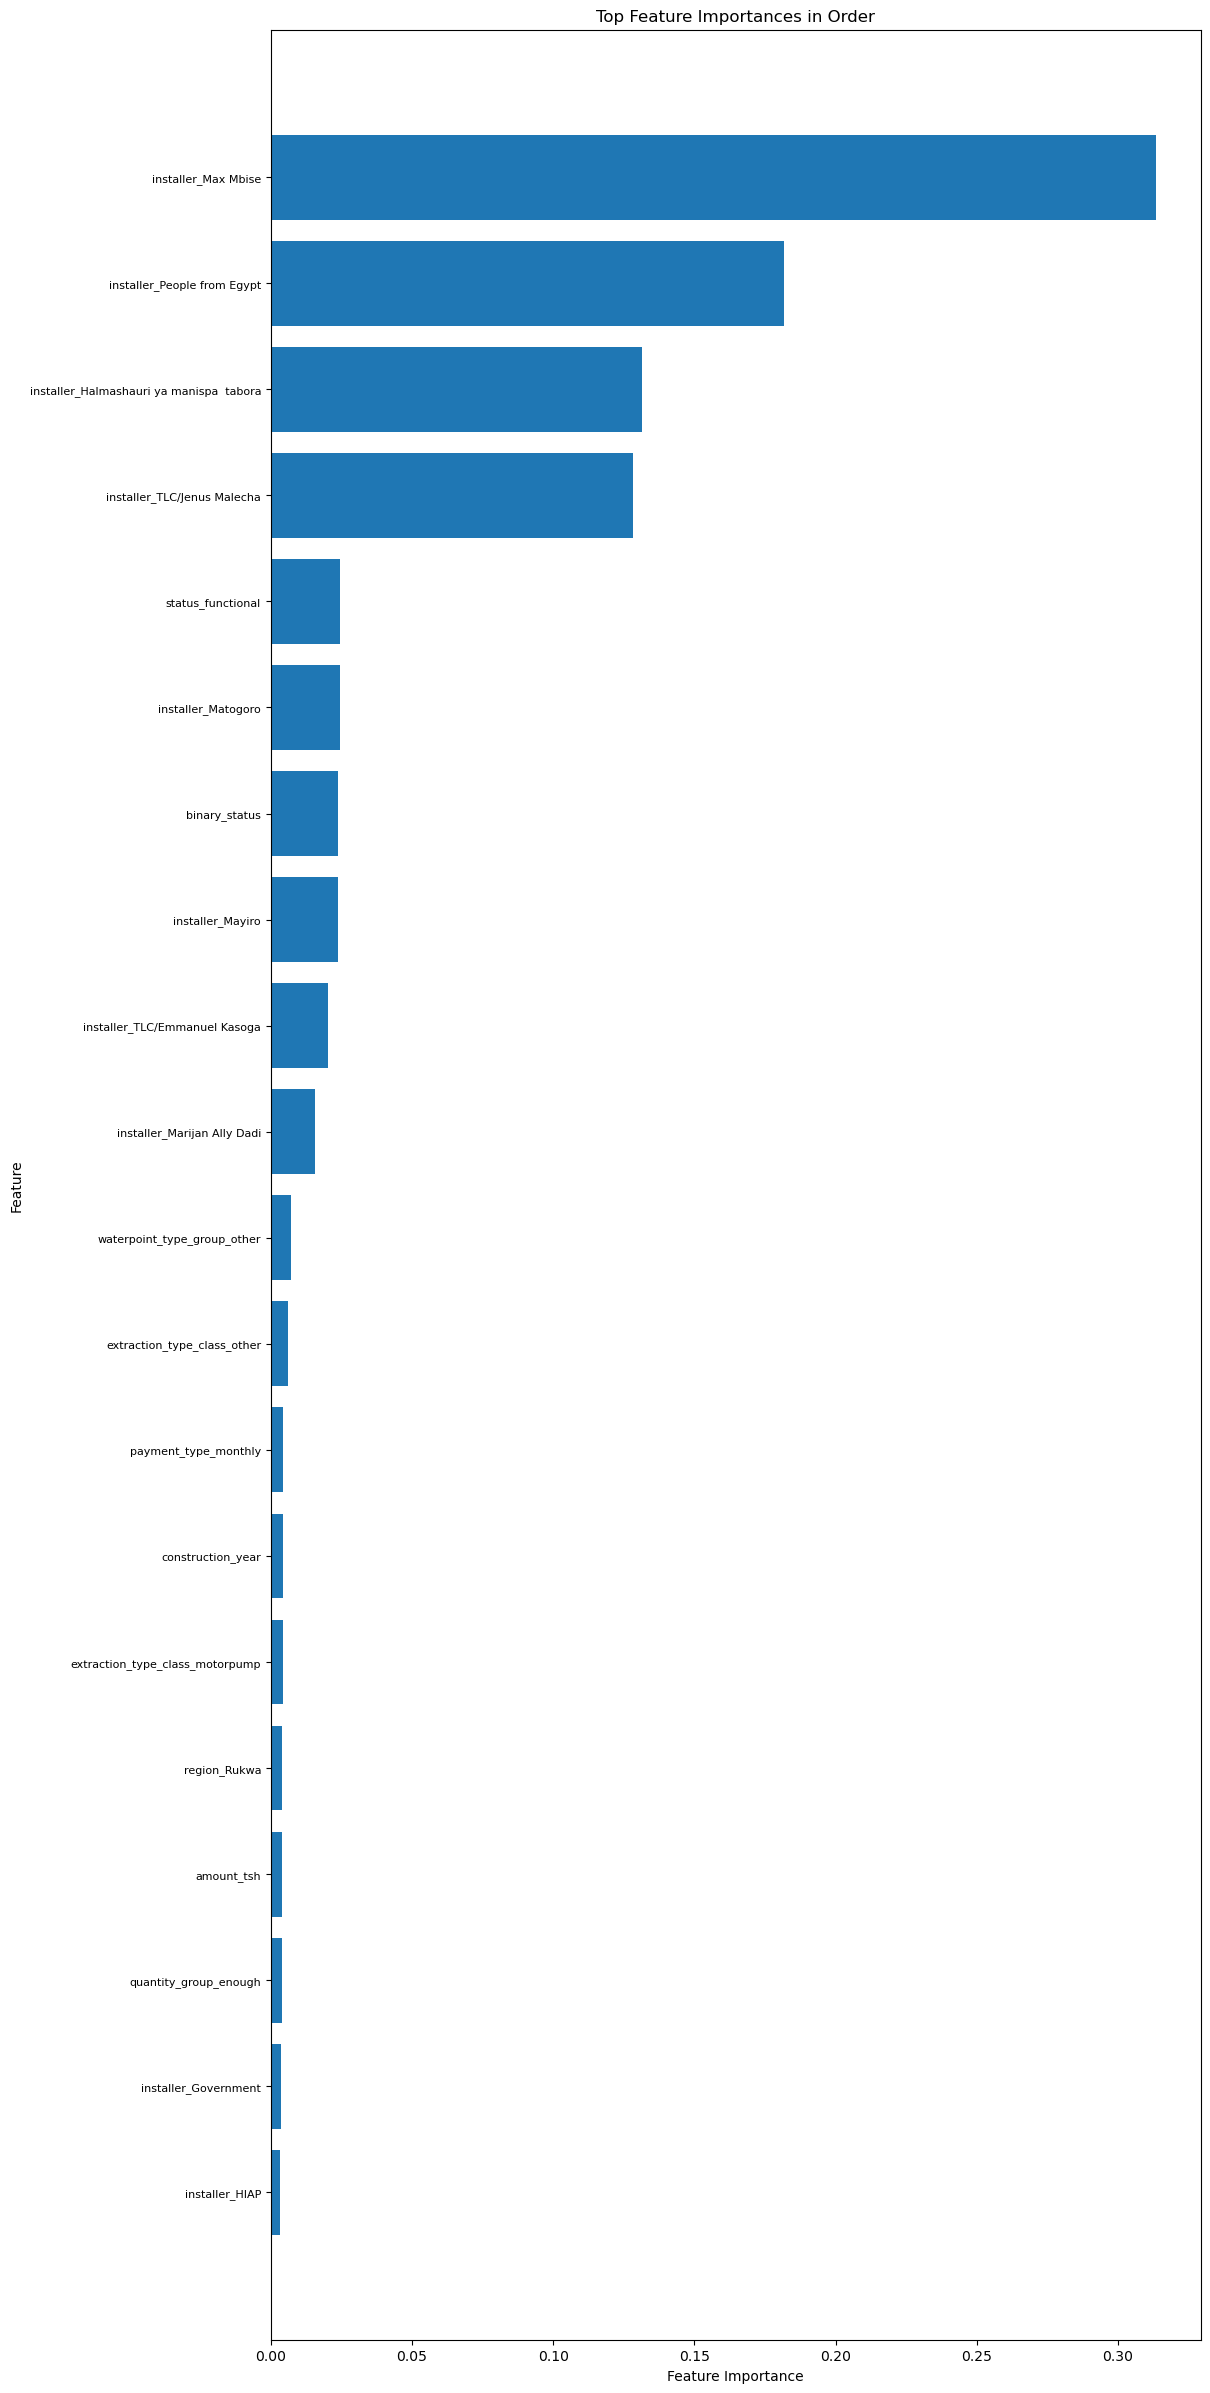

In [55]:
# Fit a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Retrieve the coefficients for each feature and class
coefficients = logistic_model.coef_

# Calculate feature importances based on the absolute values of coefficients
importances = np.abs(coefficients)

# Normalize the importances within each class
importances /= np.sum(importances, axis=1)[:, np.newaxis]

# Aggregate importances across classes for an overall importance measure
# Mean importance across classes
overall_importance = np.mean(importances, axis=0)

# Sort and plot feature importances
sorted_indices = overall_importance.argsort()
sorted_feature_names = X_train.columns[sorted_indices]

plt.figure(figsize=(12, 30)) 

# Plot of only the top N features (top 20)
N = 20
top_indices = sorted_indices[-N:]

plt.barh(range(N), overall_importance[top_indices], align='center')
plt.yticks(range(N), sorted_feature_names[top_indices], fontsize=8) 
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances in Order')
plt.show()

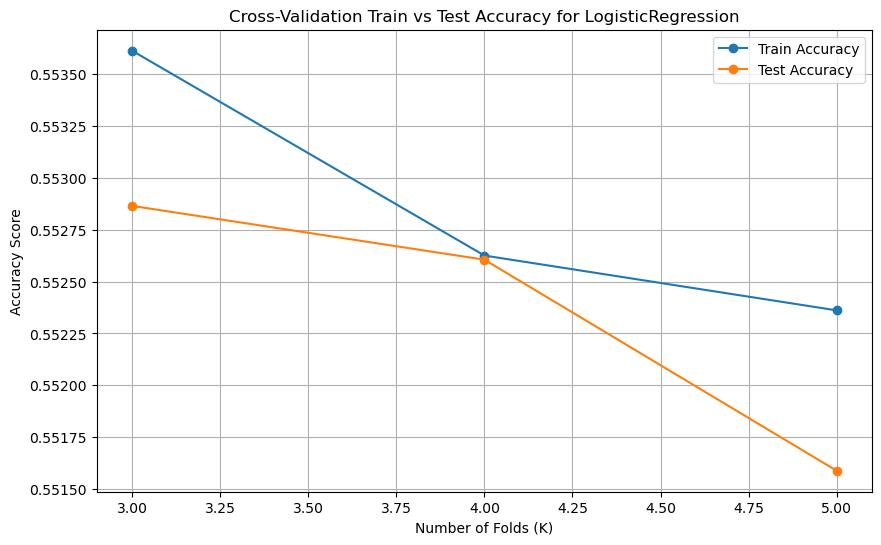

'Cross-validation test completed for LogisticRegression'

In [56]:
from sklearn.model_selection import cross_validate

def cross_val_test(K_folds, model_instance, X, y):
    
    # Lists to store train and test accuracy scores
    train_accuracy = []
    test_accuracy = []

    for fold in K_folds:
        # Perform cross-validation on full dataset to evaluate model performance
        cv_results = cross_validate(model_instance, X, y, cv=fold, return_train_score=True, n_jobs=-1)

        # Append the mean scores for each fold
        train_accuracy.append(np.mean(cv_results['train_score']))
        test_accuracy.append(np.mean(cv_results['test_score']))
    
    # Convert lists to numpy arrays for more efficient plotting
    train_accuracy = np.array(train_accuracy)
    test_accuracy = np.array(test_accuracy)
    
    # Plot the mean train and test scores against K folds
    plt.figure(figsize=(10, 6))
    plt.plot(K_folds, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(K_folds, test_accuracy, label='Test Accuracy', marker='o')
    plt.xlabel('Number of Folds (K)')
    plt.ylabel('Accuracy Score')
    plt.title(f'Cross-Validation Train vs Test Accuracy for {model_instance.__class__.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return f"Cross-validation test completed for {model_instance.__class__.__name__}"

cross_val_test(range(3, 6), LogisticRegression(random_state=42), X, y)


#### DECISION TREE CLASSIFIER

In [57]:
# Fit the decision tree classifier to training data
dt_model = pipe_decision_tree.fit(X_train, y_train)

# Print the accuracy on test set
pipe_decision_tree.score(X_test, y_test)

0.9139924257524417

                         precision    recall  f1-score   support

             functional       0.93      0.92      0.92      5579
functional needs repair       0.39      0.43      0.41       689
         non functional       1.00      1.00      1.00      3766

               accuracy                           0.91     10034
              macro avg       0.77      0.78      0.78     10034
           weighted avg       0.92      0.91      0.92     10034

Overall accuracy score 0.9139924257524417
Overall precision score 0.9182597840637288
Overall recall score 0.9139924257524417
Overall F1-score 0.9160174910575444

Confusion Matrix


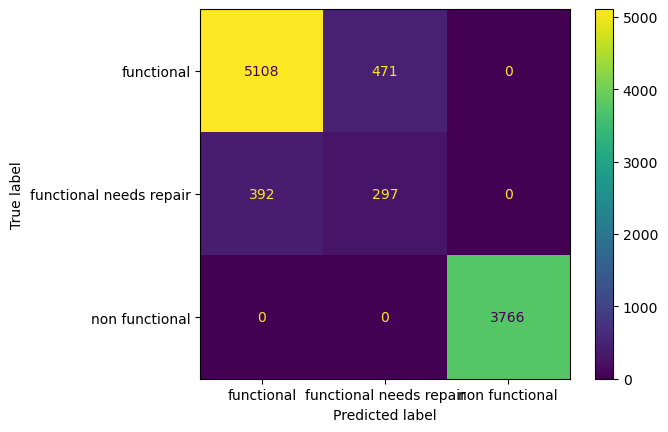

In [58]:
# Predict target
y_pred = dt_model.predict(X_test)

# Create metrics object
score_metrics = Metrics()

# Print classification report, scores, and confusion matrix
score_metrics.model_score(dt_model, y_test, y_pred)

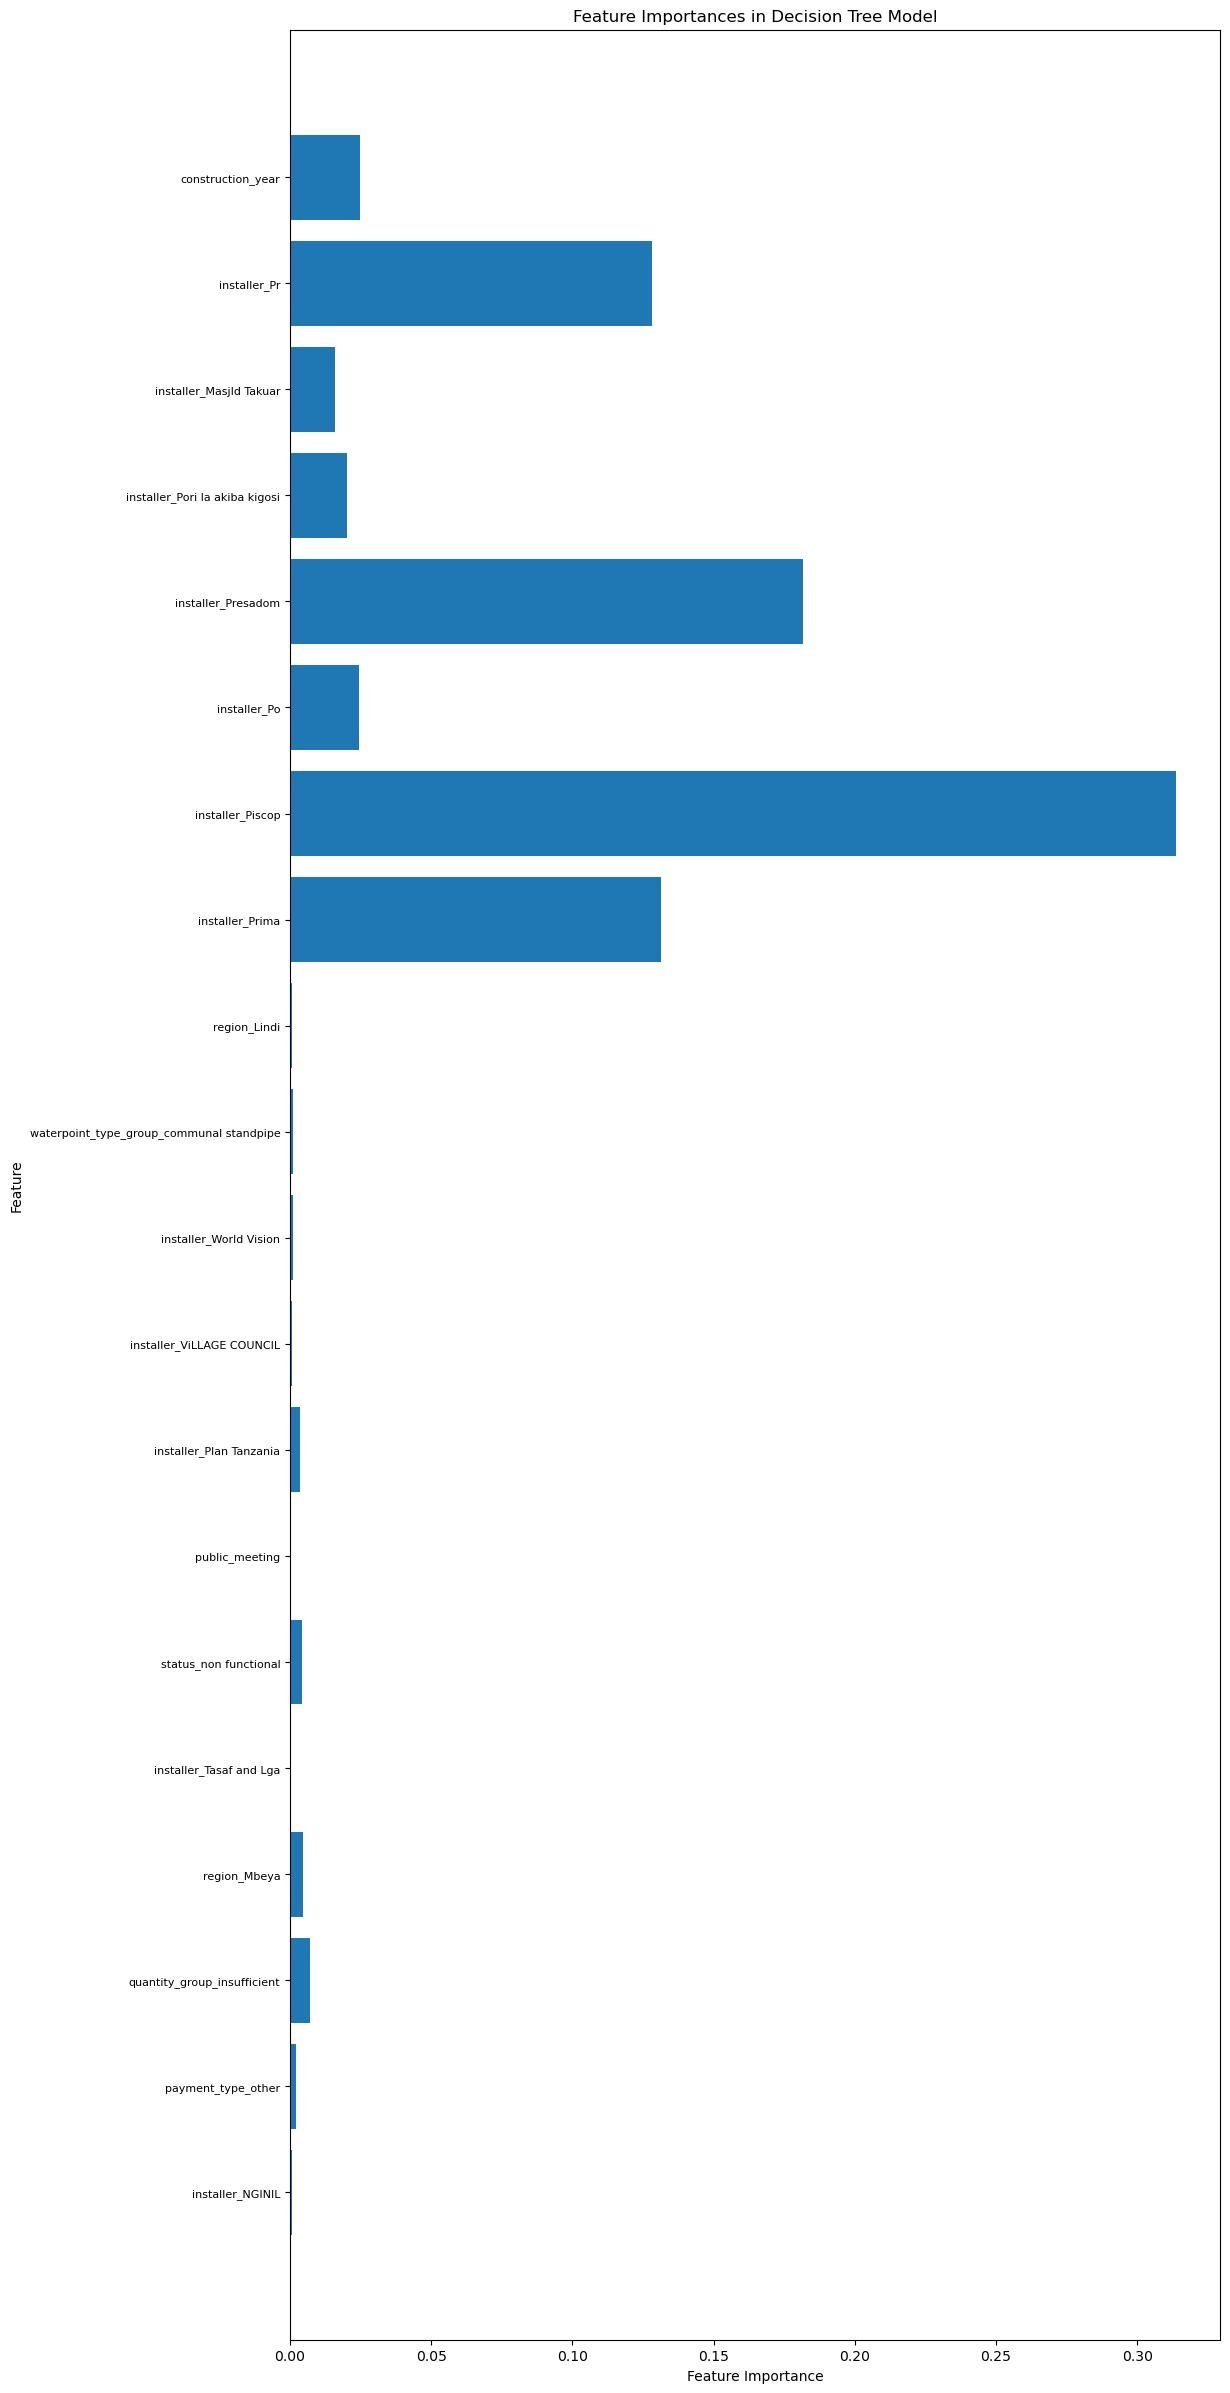

In [59]:
# Fit the decision tree classifier to training data
dt_model_f = pipe_decision_tree.named_steps['tree'].fit(X_train, y_train)

# Get feature importances from the decision tree
feature_importances = dt_model_f.feature_importances_

# Continue with the rest of your code
n_features = X_train.shape[1]
sorted_indices = feature_importances.argsort()
# Sort feature names based on importance order
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(12, 30)) 

# Plot of only the top N features (top 20)
N = 20
top_indices = sorted_indices[-N:]
plt.barh(range(N), overall_importance[top_indices], align='center')
plt.yticks(range(N), sorted_feature_names[top_indices], fontsize=8) 
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Decision Tree Model');

##### DECISION TREE CLASSIFIER WITH CROSS VALIDATION

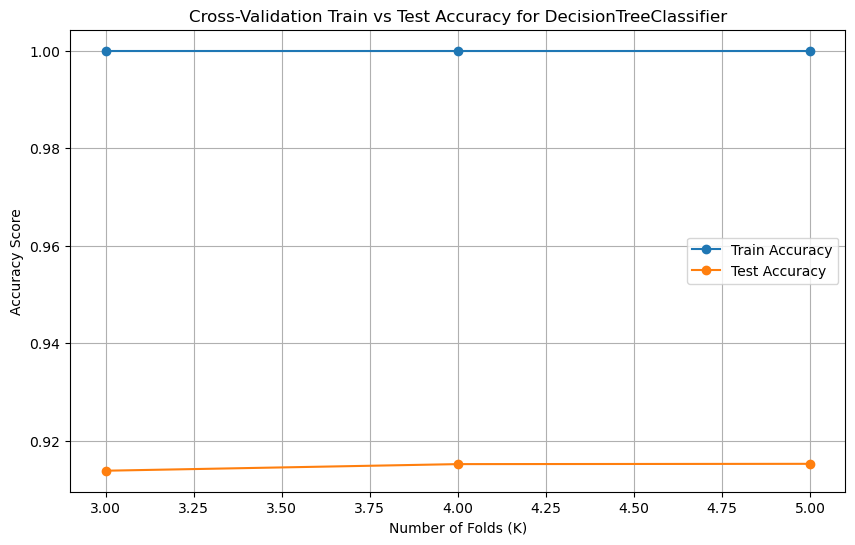

'Cross-validation test completed for DecisionTreeClassifier'

In [60]:
# Distribution of train and test accuracies over a range of K folds
cross_val_test(range(3, 6), DecisionTreeClassifier(random_state=42), X, y)

##### HANDLING THE IMBALANCE

In [61]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

status_group
functional                 22309
non functional             14900
functional needs repair     2923
Name: count, dtype: int64


status_group
functional                 22309
non functional             22309
functional needs repair    22309
Name: count, dtype: int64


In [62]:
# Fit logistic regression, decision tree, and KNN classifiers 
# resampled data

# Print the baseline logistic accuracy and f1 score on test set
y_pred = log_model.predict(X_test)
print("Baseline Logistic Regression Accuracy", log_model.score(X_test, y_test))
print("Baseline Logistic Regression F1-score", f1_score(y_test, y_pred, average='weighted'))

# Print the baseline decision tree accuracy and f1 score on test set
y_pred = dt_model.predict(X_test)
print("Baseline Decision Tree Accuracy", pipe_decision_tree.score(X_test, y_test))
print("Baseline Decision Tree F1-score", f1_score(y_test, y_pred, average='weighted'))

# Fit the logistic regression model on resampled data
log_model_resampled = pipe_logistic.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_model_resampled.predict(X_test)

# Fit the decision tree classifier on resampled data
dt_model_resampled = pipe_decision_tree.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_model_resampled.predict(X_test)
# Print the accuracy and f1 scores on SMOTE sample
print("Logistic Regression Accuracy with SMOTE", log_model_resampled.score(X_test, y_test))
print("Logistic Regression F1-score with SMOTE", f1_score(y_test, y_pred_log, 
                                                          average='weighted'))
print("Decision Tree Accuracy with SMOTE", dt_model_resampled.score(X_test, y_test))
print("Decision Tree F1-score with SMOTE", f1_score(y_test, y_pred_dt, 
                                                          average='weighted'))

Baseline Logistic Regression Accuracy 0.9364161849710982
Baseline Logistic Regression F1-score 0.9218428472967931
Baseline Decision Tree Accuracy 0.5605939804664142
Baseline Decision Tree F1-score 0.6002894371513324
Logistic Regression Accuracy with SMOTE 0.9365158461231812
Logistic Regression F1-score with SMOTE 0.9245022712645242
Decision Tree Accuracy with SMOTE 0.9168825991628463
Decision Tree F1-score with SMOTE 0.9186762932212614
